In [72]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold  
from sklearn.feature_selection import SelectPercentile, f_regression
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

In [73]:
train = pd.read_csv("../data/processed/train.csv")
test = pd.read_csv("../data/processed/test.csv")

In [74]:
train.pop("id")
test.pop("id")
target = train.pop("血糖")

In [75]:
train_x= train.as_matrix()
train_y = target.as_matrix()
test_x = test.as_matrix()

In [76]:
lgb_train = lgb.Dataset(train_x, train_y)

In [77]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'mse'},
    'num_leaves': 17,
    'learning_rate': 0.01,
    'lambda_l1': 1,
    'lambda_l2': 0.5,
    'cat_smooth': 10,
    'feature_fraction': 0.5,
    'bagging_fraction':0.5,
    'bagging_freq': 5,
    'verbose': 0
}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500)
predict = gbm.predict(test_x)

In [78]:
result = pd.DataFrame()

In [79]:
result[0] = predict

In [80]:
result.to_csv("../result/1.7-0.97944.csv", header=None, index=False,encoding="utf-8")

In [81]:
result.describe()

,0
count,1000.000000
mean,5.654015
std,0.644796
min,4.849346
25%,5.184804
50%,5.474424
75%,5.937733
max,10.303130


In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

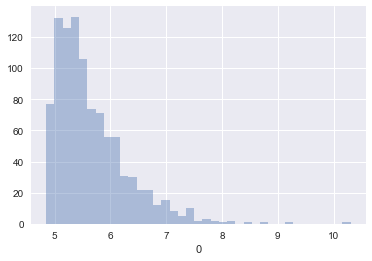

In [83]:
sns.distplot(result[0], kde=False)
plt.show()

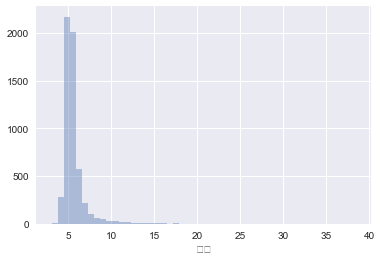

In [84]:
sns.distplot(target, kde=False)
plt.show()

In [85]:
comp = pd.DataFrame({"true":target,"predict":result[0]})

In [86]:
comp.describe()

,predict,true
count,1000.000000,5642.000000
mean,5.654015,5.631925
std,0.644796,1.544882
min,4.849346,3.070000
25%,5.184804,4.920000
50%,5.474424,5.290000
75%,5.937733,5.767500
max,10.303130,38.430000
